# **Citation Network Classification**

# **Citation Network Classification**

In this notebook, we will explore how to learn representations on a graph using graph convolutions.
We will use the CoraGraphDataset from https://graphsandnetworks.com/the-cora-dataset/.

The Cora dataset consists of 2708 scientific publications classified into one of seven classes, with a citation network of 5429 links. Each publication is represented by a binary word vector of length 1433, indicating the presence/absence of the corresponding word. The adjacency matrix for this dataset is a 2708x2708 matrix, representing the directional citation relationships between papers.

In [ ]:
# !pip install torch==2.0.0
# !pip install torchdata==0.6.0
# !pip install dgl

Graph convolutions differ from traditional convolutions in that they operate over graph structures rather than grids (e.g., images). In graph convolutions, the representation for each node is influenced by its neighbors, similar to how image convolutions involve surrounding pixels. This tutorial will use DGL for graph convolutions, leveraging its simplified graph learning setup.

In [6]:
# imports
import numpy as np
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.data import CoraGraphDataset

import matplotlib.pyplot as plt
import networkx as nx

In [7]:
# Load the dataset
dataset = CoraGraphDataset()
print('Number of categories:', dataset.num_classes)

/root/.dgl/cora_v2.zip:   0%|          | 0.00/132k [00:00<?, ?B/s]

Extracting file to /root/.dgl/cora_v2_d697a464
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.
Number of categories: 7


In [8]:
# The dataset contains one graph
g = dataset[0]

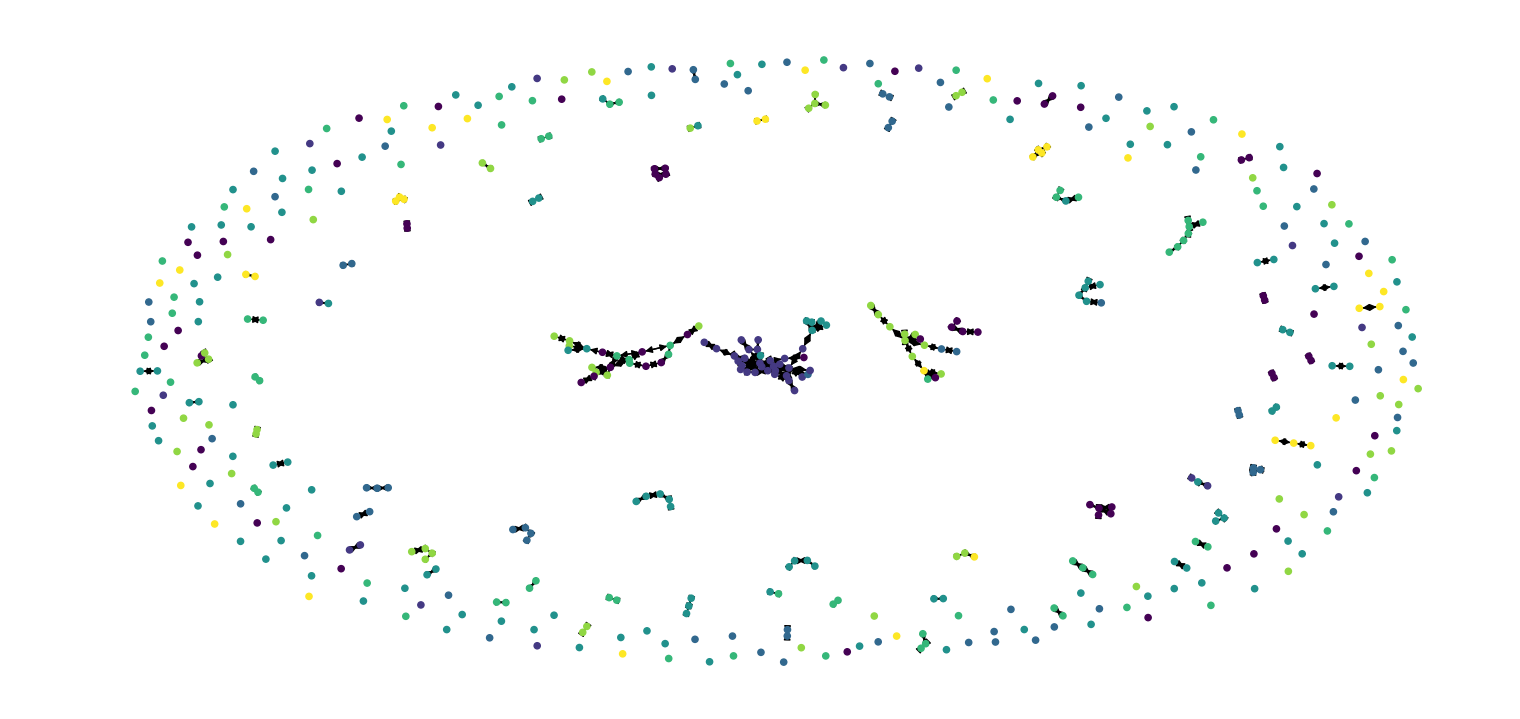

In [9]:
# Visualize a subset of the graph for efficiency
num_visualize = 500
if num_visualize is not None:
    g2 = g.subgraph(np.arange(num_visualize))
else:
    g2 = g

# Visualization options
options = {
    'node_size': 20,
    'width': 1,
    'node_color': g2.ndata['label'].numpy()
}

# Convert DGL graph to NetworkX for visualization
G = dgl.to_networkx(g2)
plt.figure(figsize=[15, 7])
nx.draw(G, **options)

The Cora dataset has 2708 nodes, each with 1433 binary features. Edges in this graph have no features, and there are no self-connections since a paper cannot cite itself.

In [10]:
# Print node and edge features
print('Node features:')
print(g.ndata)
print('Edge features:')
print(g.edata)

Node features:
{'train_mask': tensor([ True,  True,  True,  ..., False, False, False]), 'val_mask': tensor([False, False, False,  ..., False, False, False]), 'test_mask': tensor([False, False, False,  ...,  True,  True,  True]), 'label': tensor([3, 4, 4,  ..., 3, 3, 3]), 'feat': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])}
Edge features:
{}


### Modeling
We define a GCN model to classify the nodes into seven categories. The GraphConv layer in DGL handles the graphical details, making it easier to implement graph convolutions.

In [18]:
# Define the GCN model
from dgl.nn import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.linear = nn.Linear(h_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.leaky_relu(h, 0.2)
        h = self.linear(h)
        h = F.leaky_relu(h, 0.2)
        h = self.conv2(g, h)
        return h

Here I set up a basic training procedure. Note that this is just a prototype and we have ignored minibatch optimization, just to show we are capable of learning on a graph. Feel free to expand on this to improve performance by implementing minibatches.

In [19]:
# Define the training procedure
def train(g, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=1e-3)
    best_val_acc = 0
    best_test_acc = 0

    features = g.ndata['feat']
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    val_mask = g.ndata['val_mask']
    test_mask = g.ndata['test_mask']

    for epoch in range(100):
        # Forward pass
        logits = model(g, features)

        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss for training nodes only
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])

        # Compute accuracy on training/validation/test sets
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        # Save the best validation and test accuracy
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 5 == 0:
            print(f'Epoch {epoch}, Loss: {loss:.3f}, Val Acc: {val_acc:.3f} (Best: {best_val_acc:.3f}), Test Acc: {test_acc:.3f} (Best: {best_test_acc:.3f})')

# Initialize and train the model
model = GCN(g.ndata['feat'].shape[1], 512, dataset.num_classes)
train(g, model)

Epoch 0, Loss: 1.944, Val Acc: 0.162 (Best: 0.162), Test Acc: 0.149 (Best: 0.149)
Epoch 5, Loss: 1.885, Val Acc: 0.292 (Best: 0.292), Test Acc: 0.306 (Best: 0.306)
Epoch 10, Loss: 1.621, Val Acc: 0.494 (Best: 0.494), Test Acc: 0.474 (Best: 0.474)
Epoch 15, Loss: 0.974, Val Acc: 0.722 (Best: 0.722), Test Acc: 0.735 (Best: 0.735)
Epoch 20, Loss: 0.370, Val Acc: 0.784 (Best: 0.784), Test Acc: 0.785 (Best: 0.785)
Epoch 25, Loss: 0.122, Val Acc: 0.790 (Best: 0.790), Test Acc: 0.798 (Best: 0.793)
Epoch 30, Loss: 0.054, Val Acc: 0.800 (Best: 0.802), Test Acc: 0.797 (Best: 0.795)
Epoch 35, Loss: 0.043, Val Acc: 0.802 (Best: 0.804), Test Acc: 0.796 (Best: 0.800)
Epoch 40, Loss: 0.060, Val Acc: 0.796 (Best: 0.804), Test Acc: 0.791 (Best: 0.800)
Epoch 45, Loss: 0.119, Val Acc: 0.784 (Best: 0.804), Test Acc: 0.777 (Best: 0.800)
Epoch 50, Loss: 0.080, Val Acc: 0.804 (Best: 0.804), Test Acc: 0.789 (Best: 0.800)
Epoch 55, Loss: 0.088, Val Acc: 0.736 (Best: 0.804), Test Acc: 0.741 (Best: 0.800)
Epoch 

### Edge Prediction
Next, we explore edge prediction, a more complex task where we predict whether a citation relationship exists between two papers. This involves formulating the problem as a binary classification task.

#### Overview of Link Prediction with GNN
Many applications such as social recommendation, item recommendation, knowledge graph completion, etc., can be formulated as link prediction, which predicts whether an edge exists between two particular nodes. This tutorial shows an example of predicting whether a citation relationship, either citing or being cited, between two papers exists in a citation network.

This tutorial formulates the link prediction problem as a binary classification problem as follows:

* Treat the edges in the graph as positive examples.

* Sample a number of non-existent edges (i.e. node pairs with no edges between them) as negative examples.

* Divide the positive examples and negative examples into a training set and a test set.

* Evaluate the model with any binary classification metric such as Area Under Curve (AUC).


In [20]:
# Adding an import to handle sparse edge connections
import scipy.sparse as sp

In [21]:
# Split edge set for training and testing
u, v = g.edges()

eids = np.arange(g.number_of_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * 0.1)
train_size = g.number_of_edges() - test_size
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

# Find all negative edges and split them for training and testing
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

neg_eids = np.random.choice(len(neg_u), g.number_of_edges())
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]

train_g = dgl.remove_edges(g, eids[:test_size])


This section creates training and testing datasets for edge prediction by splitting edges into positive and negative examples. The dataset is treated as a classification task, where pairs of research papers are classified as having a citation link (positive) or not (negative).

In [22]:
# Define the GraphSAGE model
from dgl.nn import SAGEConv

class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [23]:
# Create positive and negative training and testing graphs
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())
test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

Our GraphSAGE model builds vector representations of nodes. To predict edges, we use a dot product of node embeddings or a more complex MLP-based approach.

In [24]:
import dgl.function as fn

# Define a dot product predictor
class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return g.edata['score'][:, 0]

Alternatively, recognize we don't have to use the dot product. If we wanted to learn more complex relations, or if we just enjoy drawing deeper networks, below we show another style of node comparison.

In [25]:
class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        """
        Computes a scalar score for each edge of the given graph.

        Parameters
        ----------
        edges :
            Has three members ``src``, ``dst`` and ``data``, each of
            which is a dictionary representing the features of the
            source nodes, the destination nodes, and the edges
            themselves.

        Returns
        -------
        dict
            A dictionary of new edge features.
        """
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

In [26]:
# Choose the predictor model
use_mlp = False
model = GraphSAGE(train_g.ndata['feat'].shape[1], 16)
pred = MLPPredictor(16) if use_mlp else DotPredictor()

# Define loss and evaluation functions
def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In [27]:
# Setup optimizer
optimizer = torch.optim.Adam(list(model.parameters()) + list(pred.parameters()), lr=0.01)

# Training loop
all_logits = []
for epoch in range(100):
    # Forward pass
    h = model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Evaluate the model
from sklearn.metrics import roc_auc_score
with torch.no_grad():
    h = model(train_g, train_g.ndata['feat'])
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC', compute_auc(pos_score, neg_score))

Epoch 0, Loss: 0.7123953700065613
Epoch 5, Loss: 0.691211462020874
Epoch 10, Loss: 0.6746953129768372
Epoch 15, Loss: 0.625133216381073
Epoch 20, Loss: 0.5490410923957825
Epoch 25, Loss: 0.5159302353858948
Epoch 30, Loss: 0.48839545249938965
Epoch 35, Loss: 0.46463873982429504
Epoch 40, Loss: 0.44690099358558655
Epoch 45, Loss: 0.42728984355926514
Epoch 50, Loss: 0.41080862283706665
Epoch 55, Loss: 0.39436015486717224
Epoch 60, Loss: 0.37819746136665344
Epoch 65, Loss: 0.36205896735191345
Epoch 70, Loss: 0.34571143984794617
Epoch 75, Loss: 0.3291381597518921
Epoch 80, Loss: 0.31213146448135376
Epoch 85, Loss: 0.2946290373802185
Epoch 90, Loss: 0.2767452597618103
Epoch 95, Loss: 0.25845640897750854
AUC 0.852471417982525


**Observation:**

- The training loss consistently decreases from 0.712 to 0.258, indicating effective learning and optimization.

**AUC Score:**

- AUC: 0.852

**Interpretation:**

- An AUC score of 0.852 indicates that the model is performing well in distinguishing between positive and negative edges.
- The high AUC suggests good model performance with an 85.2% chance of correctly ranking positive instances higher than negative ones.

**Summary:**

- Effective Training: The steady decrease in loss shows the model is learning well.
- Good Performance: The high AUC score demonstrates strong generalization to unseen data.

**Next Steps:**

- Early Stopping: Implement early stopping to prevent overfitting.
- Hyperparameter Tuning: Experiment with learning rates, hidden dimensions, etc.
- Regularization: Use dropout or other techniques if overfitting occurs.
- Mini-Batch Training: Improve efficiency and performance.
- Model Variations: Test different GNN layers (e.g., GAT, GIN) for potential improvements.

These steps can help further refine the model and enhance its performance.